# Deconvolution and reconvolution by the common beam

In [71]:
import numpy as np
import pylab
import healpy as hp
import pysm3 
import pysm3.units as u
import matplotlib.pyplot as py


In [72]:
import cmbdb as cmb


In [73]:
from fgbuster.mixingmatrix import MixingMatrix
from fgbuster.component_model import CMB, Dust, Synchrotron
from fgbuster.separation_recipes import basic_comp_sep

In [74]:
from fgbuster.observation_helpers import get_instrument,get_noise_realization,get_sky,get_observation

In [75]:
from fgbuster.cosmology import _get_Cl_noise

# Simulating Sky

In [76]:
NSIDE = 64
lmax = 3*NSIDE-1  # Maximum ell value based on the given NSIDE value
sky_d0s0 = get_sky(NSIDE, 'd0s0')  # Get the sky map using the specified NSIDE and sky type 'd0s0'

instrument = get_instrument('LiteBIRD')  # Get the instrument information for 'LiteBIRD'

freq_maps_d0s0 = get_observation(instrument, sky_d0s0)
# Obtain the frequency maps for the given instrument and sky map.
# freq_maps_d0s0 is a 3D array containing the observed maps for each frequency channel.

num_freq, ncomp, npix = freq_maps_d0s0.shape
# Retrieve the dimensions of the freq_maps_d0s0 array.
# - num_freq represents the number of frequency channels.
# - ncomp represents the number of components in the observed map.
# - npix represents the number of pixels in the observed map.


/home/julientang2001/fgbuster/fgbuster/observation_helpers.py:97: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  return df.dropna(1, 'all')


#### Create CMB map

Using Planck 2018, compute a CMB map of specified NSIDE. This will be the input map.
Retrieve the cls from the map. 

In [77]:
cl_CMB_th = hp.read_cl("/home/julientang2001/Stage3A/Cls_Planck2018_lensed_scalar.fits")

cl_CMB_crop_th = cl_CMB_th[:,:lmax+1]

np.random.seed(0)
map_CMB = hp.synfast(cl_CMB_th,nside=NSIDE,new = True)


In [78]:
cl_CMB6 = hp.anafast(map_CMB,lmax=lmax,alm = False)
cl_CMB = cl_CMB6[:4]
print(cl_CMB.shape)

(4, 192)


The power spectrum $C_{\ell}$ contains (TT, EE, BB, TE, EB, TB).

In [79]:
print(cl_CMB_th[:,:lmax+1].shape)


(4, 192)


In [80]:

map_CMB_QU = map_CMB[1:3]
print(map_CMB_QU.shape)

(2, 49152)


#### Noise maps

We use LiteBIRD specifications to simulate a noise map.

In [81]:
freq_maps_simple_noiseless = np.array([np.add(map_CMB,map_d0s0) for map_d0s0 in freq_maps_d0s0])
np.random.seed(0)

freq_map_noise = get_noise_realization(NSIDE,instrument#,unit = 'uK_CMB'
                                       )

amin2rad = np.pi/(60.*180.)

## Beam (check with hp.smoothing)

For each frequency channel, we compute a polarized beam of specified full width half maximum.

In [82]:
beam_array = np.array([hp.gauss_beam(f*amin2rad,lmax = lmax, pol=True) for f in instrument.fwhm])
print(beam_array.shape)


(15, 192, 4)


The inverse beam is needed for the deconvolution. We also compute the common beam of width 80'.

In [83]:
inv_beam_arr = 1/beam_array
fwhm_common = 80*amin2rad
beam_common = hp.gauss_beam(fwhm_common,lmax = lmax, pol = True)
b_c = np.array([beam_common*beam_inv for beam_inv in inv_beam_arr])
print(b_c.shape)

(15, 192, 4)


The maps have 3 Stokes parameters $(I,Q,U)$ and span over $n_{pix}$ pixels.
The beams are polarized, contain : (temperature beam,grad/electric polarization beam,curl/magnetic polarization beam, temperature * grad beam).
They cover multipoles up to $l_{max}$.

In [84]:
print(map_CMB.shape,beam_common.shape)

(3, 49152) (192, 4)


#### Smoothing CMB map with common beam? Does that make sense?

In [85]:
map_CMB_smooth = np.array([hp.smoothing(map_CMB[j,:],beam_window=beam_common[:,j]) for j in range(0,ncomp)])
print(map_CMB_smooth.shape)

map_CMB_smooth_QU =map_CMB_smooth[1:3]
print(map_CMB_smooth_QU.shape)

cl_CMB_smooth = hp.anafast(map_CMB_smooth,lmax=lmax,alm=False)

(3, 49152)
(2, 49152)


In [86]:
print(freq_maps_simple_noiseless[0,0].shape)
print(beam_array[0,0].shape)

(49152,)
(4,)


In [87]:
print(inv_beam_arr.shape)

(15, 192, 4)


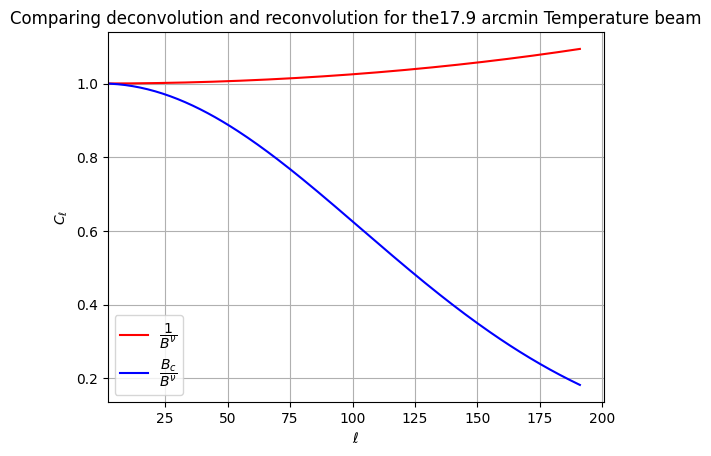

In [88]:
l_arr = np.arange(0,lmax+1,1)
fig = py.figure()
ax1 = fig.add_subplot(111)
ax1.plot(l_arr, inv_beam_arr[14,:,0], 'r', label='$\dfrac{1}{B^{\\nu}}$')
ax1.plot(l_arr, b_c[14,:,0], 'b', label='$\dfrac{B_c}{B^{\\nu}}$')

ax1.set_xlim(left=2)  # Set the left limit for x-axis

ax1.set_xlabel('$\ell$')  # Set the x-axis label
ax1.set_ylabel('$C_{\ell}$')  # Set the y-axis label
ax1.set_title('Comparing deconvolution and reconvolution for the'+str(instrument.fwhm[14])+' arcmin Temperature beam')  # Set the plot title

ax1.grid(True)  # Enable grid lines

ax1.legend()  # Show the legend

py.show()  # Display the plot

#### Beaming maps

We want to compute $(B \ast As+n)_p$.
We start with convolution of the noiseless signal.

In [89]:
BAS_p_nl_smooth = np.array([np.array([hp.smoothing(freq_maps_simple_noiseless[i,j],beam_window=beam_array[i,:,j]) for j in range(0,ncomp) ]) for i in range(0,num_freq)])
print(BAS_p_nl_smooth.shape)

(15, 3, 49152)


In [90]:
BAS_p = np.add(BAS_p_nl_smooth,freq_map_noise)


Let us compare $\frac{1}{B^{\nu}}(B^{\nu}  \ast A^{\nu} s+n)_p$ and $\frac{B^{c}}{B^{\nu}}(B^{\nu}  \ast A^{\nu} s+n)_p$.

In [91]:
AS_p_inv = np.array([np.array([hp.smoothing(BAS_p[i,j],beam_window=inv_beam_arr[i,:,j]) for j in range(0,ncomp) ]) for i in range(0,num_freq)])

AS_p_ren = np.array([np.array([hp.smoothing(BAS_p[i,j],beam_window=b_c[i,:,j]) for j in range(0,ncomp) ]) for i in range(0,num_freq)])

In [92]:
AS1_QU_p = AS_p_inv[:,1:3,:]
print(AS1_QU_p.shape)

(15, 2, 49152)


In [93]:
BAS_QU_p = BAS_p[:,1:3,:]
print(BAS_QU_p.shape)

(15, 2, 49152)


In [94]:
AS2_QU_p = AS_p_ren[:,1:3,:]
print(AS2_QU_p.shape)

(15, 2, 49152)


## Component separation

Components are CMB, Dust and Synchrotron.

In [95]:
components = [CMB(), Dust(353.), Synchrotron(23.)]


In [96]:
# The starting point of the fit is the ax1sm default value, so let's shift it
components[1].defaults = [1.54, 20.]
components[2].defaults = [-3.0]
A = MixingMatrix(*components) ##Matrix evaluator
A_ev = A.evaluator(instrument.frequency)
i_cmb = A.components.index('CMB')

In [97]:
result_beam_inv = basic_comp_sep(components,instrument,AS_p_inv[:,1:3,:])


In [98]:
print(result_beam_inv.s.shape)

(3, 2, 49152)


In [99]:
result_beam_ren = basic_comp_sep(components,instrument,AS_p_ren[:,1:3,:])


In [100]:
print(result_beam_ren.s.shape)

(3, 2, 49152)


### Get noise

We now want to retrieve the noise from both component separations.

In [101]:
A_beam_inv = A_ev(result_beam_inv.x)

In [102]:
A_beam_ren = A_ev(result_beam_ren.x)

In [103]:
print(A_beam_ren.shape)

(15, 3)


I have rewritten a function to retrieve the noise power spectrum with input a window function. The previous function worked only with unpolarized gaussian beams.

In [104]:
def _get_Cl_noise_nofwhm(instrument,window, A, lmax):
    nl = (window / np.radians(instrument.depth_p/60.)[:, np.newaxis])**2
    AtNA = np.einsum('fi, fl, fj -> lij', A, nl, A)
    inv_AtNA = np.linalg.inv(AtNA)
    return inv_AtNA.swapaxes(-3, -1)

In [105]:
print(inv_beam_arr.shape)

(15, 192, 4)


In [106]:

cl_beam_inv1 =_get_Cl_noise_nofwhm(instrument=instrument,window = inv_beam_arr[:,:,0],A = A_beam_inv,lmax=lmax)[i_cmb, i_cmb, :]
cl_beam_ren1 =_get_Cl_noise_nofwhm(instrument=instrument,window = b_c[:,:,0], A = A_beam_ren,lmax=lmax)[i_cmb, i_cmb, :]
print(cl_beam_ren.shape)


(192,)


/tmp/ipykernel_85278/2900933406.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  nl = (window / np.radians(instrument.depth_p/60.)[:, np.newaxis])**2


In [107]:
cl_beam_inv =_get_Cl_noise(instrument=instrument,A = A_beam_inv,lmax=lmax)[i_cmb, i_cmb, :]
cl_beam_ren =_get_Cl_noise(instrument=instrument, A = A_beam_ren,lmax=lmax)[i_cmb, i_cmb, :]

/home/julientang2001/fgbuster/fgbuster/cosmology.py:742: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  nl = (bl / np.radians(instrument.depth_p/60.)[:, np.newaxis])**2


In [108]:
inputs = [sky_d0s0.components[0].mbb_index,
          sky_d0s0.components[0].mbb_temperature.value,
          sky_d0s0.components[1].pl_index]
print('Basic component separation on $\dfrac{1}{B^\\nu}\\times (BAs+n)$')

print("%-20s\t%s\t%s" % ('', 'Estimated', 'Input'))

for param, val, ref in zip(result_beam_inv.params, result_beam_inv.x, inputs):
    print("%-20s\t%f\t%f" % (param, val, ref))
print('Basic component separation on $\dfrac{B^c}{B^\\nu}\\times (BAs+n)$')
print("%-20s\t%s\t%s" % ('', 'Estimated', 'Input'))
for param, val, ref in zip(result_beam_ren.params, result_beam_ren.x, inputs):
    print("%-20s\t%f\t%f" % (param, val, ref))


Basic component separation on $\dfrac{1}{B^\nu}\times (BAs+n)$
                    	Estimated	Input
Dust.beta_d         	1.545781	1.540000
Dust.temp           	19.814673	20.000000
Synchrotron.beta_pl 	-3.042133	-3.000000
Basic component separation on $\dfrac{B^c}{B^\nu}\times (BAs+n)$
                    	Estimated	Input
Dust.beta_d         	1.540893	1.540000
Dust.temp           	19.975551	20.000000
Synchrotron.beta_pl 	-3.004703	-3.000000


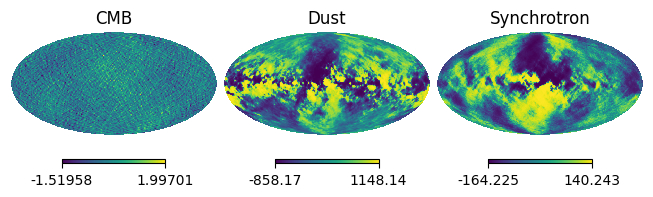

In [109]:
hp.mollview(result_beam_ren.s[0,1], title='CMB', sub=(1,3,1))
hp.mollview(result_beam_ren.s[1,1], title='Dust', norm='hist', sub=(1,3,2))
hp.mollview(result_beam_ren.s[2,1], title='Synchrotron', norm='hist', sub=(1,3,3))


# Residuals

We compare retrieved CMB maps, with input CMB maps.

In [110]:
res_CMB_QU_inv = result_beam_inv.s[0,0:2]-map_CMB_QU[0:2]
res_CMB_QU_ren = result_beam_ren.s[0,0:2]-map_CMB_QU[0:2]

print(res_CMB_QU_inv.shape,res_CMB_QU_ren.shape)

(2, 49152) (2, 49152)


In [111]:
res_CMB_inv= np.zeros((3,npix),dtype=complex)
res_CMB_inv[1:3] = res_CMB_QU_inv
print(res_CMB_inv.shape)

(3, 49152)


In [112]:
res_CMB_ren= np.zeros((3,npix),dtype=complex)
res_CMB_ren[1:3] = res_CMB_QU_ren
print(res_CMB_ren.shape)

(3, 49152)


We use the maps to retrieve the power spectrum.

In [113]:
C_l_CMB_inv=hp.anafast(res_CMB_inv,lmax = lmax,alm=False,pol=True)
C_l_CMB_ren =hp.anafast(res_CMB_ren,lmax=lmax,alm=False,pol=True)
print(C_l_CMB_inv.shape)

(6, 192)


/home/julientang2001/.conda/envs/FGBuster_JT/lib/python3.11/site-packages/healpy/sphtfunc.py:274: ComplexWarning: Casting complex values to real discards the imaginary part
  alms = _sphtools.map2alm(


In [114]:
C_EE_CMB_inv_l = C_l_CMB_inv[1]
C_BB_CMB_inv_l = C_l_CMB_inv[2]
C_EE_CMB_ren_l = C_l_CMB_ren[1]
C_BB_CMB_ren_l = C_l_CMB_ren[2]
print(C_EE_CMB_inv_l.shape)
print(C_BB_CMB_ren_l.shape)

(192,)
(192,)


### Retrieved CMB Power spectrum

In [115]:
res_ret_inv = np.zeros((3,npix),dtype=complex)
res_ret_inv[1:3] = result_beam_inv.s[0,0:2]
print(res_ret_inv.shape)
res_ret_ren = np.zeros((3,npix),dtype=complex)
res_ret_ren[1:3] = result_beam_ren.s[0,0:2]


(3, 49152)


In [116]:

C_L_ret_ren = hp.anafast(res_ret_ren,alm = False,pol=True)
print(C_L_ret_ren.shape)
C_l_ret_ren_BB = C_L_ret_ren[2]
print(C_l_ret_ren_BB.shape)
C_L_inv = hp.anafast(res_ret_inv,alm = False,pol=True)
print(C_L_inv.shape)
C_l_inv_BB = C_L_inv[2]
print(C_l_inv_BB.shape)

(6, 192)
(192,)
(6, 192)
(192,)


# + Gravitational waves

We now want to compare with the power spectrum of gravitational waves

In [117]:
cl_GW = hp.read_cl("/home/julientang2001/Stage3A/Cls_Planck2018_unlensed_scalar_and_tensor_r1.fits")
print(cl_GW.shape)
cl_GW_crop = cl_GW[:,:lmax+1]
print(cl_GW_crop.shape)

map_CMB = hp.synfast(cl_GW,nside=NSIDE)

(4, 4101)
(4, 192)


In [118]:
cl_tot_th = np.add(0.001*cl_GW_crop,cl_CMB)

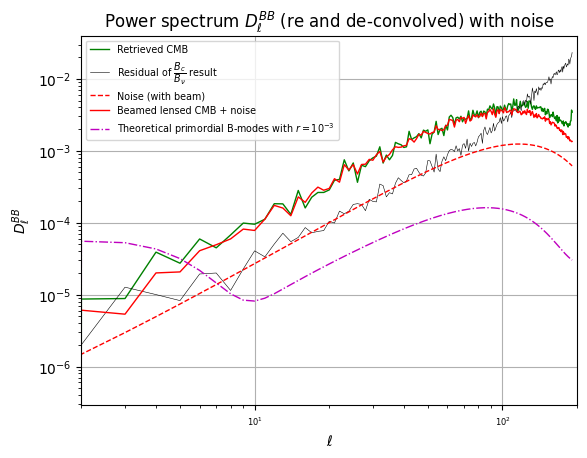

In [119]:
l_arr = np.arange(0,lmax+1,1)

py.figure(1)
ax1 = py.subplot(111)
ax1.tick_params('x', labelsize=6)
# ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*np.subtract(C_BB_CMB_inv_l,cl_beam_inv),'k',linewidth =.4,label = 'Residual of $\dfrac{1}{B_{\\nu}}$ result')
# ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*C_l_inv_BB,'g',linewidth = 1,label = 'Retrieved CMB')
# ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*cl_beam_inv,'r--',linewidth =1, label = 'Noise')
# ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*(cl_CMB[2]+cl_beam_inv),'r-',linewidth =1,label = "Lensed CMB+noise")
# py.title('Power spectrum $D_{\ell}^{BB}$ (deconvolved) with noise')

ax1.plot(l_arr,l_arr*(l_arr+1)*C_l_ret_ren_BB/np.pi,'g',linewidth = 1,label = 'Retrieved CMB')
ax1.plot(l_arr,l_arr*(l_arr+1)*C_BB_CMB_ren_l/np.pi,'k',linewidth =.4,label = 'Residual of $\dfrac{B_c}{B_{\\nu}}$ result')
ax1.plot(l_arr,l_arr*(l_arr+1)*cl_beam_ren*beam_common[:,2]**2/np.pi,'r--',linewidth =1, label = 'Noise (with beam)')
ax1.plot(l_arr,l_arr*(l_arr+1)*(cl_CMB[2]+cl_beam_ren)*beam_common[:,2]**2/np.pi,'r-',linewidth =1,label = "Beamed lensed CMB + noise")
py.title('Power spectrum $D_{\ell}^{BB}$ (re and de-convolved) with noise')
# ax1.plot(l_arr,l_arr*(l_arr+1)*cl_CMB[2]/np.pi,'b-.',linewidth =1,label = "Theoretical lensed CMB (beamed) ")
#         #  $D_{\ell,lens}^{BB}$")
ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*0.001*cl_GW_crop[2],'m-.',linewidth =1,label = "Theoretical primordial B-modes with $r=10^{-3}$")
# #         # $D_{\ell,GW}^{BB}$")


handles, labels = ax1.get_legend_handles_labels()
py.xlim(left = 2)
py.grid()
py.xlabel('$\ell$')
py.yscale("log")
py.xscale("log")
# py.ylim(-1,1)

        #  of the residuals with and without beam, with noise')

py.ylabel('$D_{\ell}^{BB}$')  
py.legend(handles,labels, loc = 'upper left', fontsize = 'x-small')
py.show()

### verifying noise + cmb

In [120]:
# map_noise_after_comp_sep = hp.anafast(cl_beam_ren,NSIDE)

In [121]:
print(np.where(cl_CMB[2]+cl_beam_ren<C_l_ret_ren_BB))

(array([ 2,  3,  4,  5,  6,  8,  9, 10, 12, 13, 14, 15, 22, 23, 32, 37, 42]),)


In [122]:
print(np.subtract(C_BB_CMB_ren_l,cl_beam_ren))

[-7.75950375e-07 -7.75987713e-07  2.74605906e-07  2.54353106e-06
  7.94955426e-07  8.76609425e-08  6.70498634e-07  3.43342753e-07
 -2.78854859e-07  1.61422755e-08  3.81593100e-07  1.89373178e-08
  2.35508509e-07  4.52988057e-07  3.48187679e-08  3.66603729e-08
  2.06532472e-07 -3.83334083e-08 -8.78446209e-08 -1.41005293e-07
 -9.66357380e-10 -1.11809391e-07  1.13722782e-07 -2.87712612e-08
 -3.01913903e-08  7.97136590e-08  3.34994896e-08 -4.56662144e-08
 -2.23413033e-07 -2.84274461e-08 -1.26172684e-07 -1.78702249e-07
  2.28102843e-07  1.19344737e-07 -1.94899953e-07 -1.48314467e-07
 -2.08381509e-07 -1.37179328e-08  8.96802579e-08 -2.70053149e-08
 -1.20531530e-07 -1.13835556e-07 -2.81363310e-09 -4.06755165e-08
  7.12185744e-08  5.11323645e-08 -8.67950694e-08 -1.83028081e-07
 -2.25755631e-07 -1.90426060e-07  7.80954617e-08  2.89699035e-08
 -1.40434620e-07 -2.76745783e-07  1.17276506e-07 -2.69323029e-07
 -3.33488949e-07 -1.62352542e-07 -8.60759923e-08 -1.98904809e-07
 -8.86863469e-08 -1.58137

# Cosmological parameters

In [123]:
def cosmo_likelihood(r,C_l_obs,noise):
    if len(C_l_obs)!=lmax+1 or len(noise)!=lmax+1:
        raise Warning("Arrays should be of size "+str(lmax))
    
    C_lth =r*cl_GW_crop[2]+cl_CMB_crop_th[2]+noise
    sig = 0
    for l in range(2,lmax):
        sig+=(2*l+1)*(np.log(C_lth[l])+C_l_obs[l]/C_lth[l])
    return (sig)


In [124]:
avg_cosmo_ren = cosmo_likelihood(r=0,C_l_obs=C_l_ret_ren_BB,noise=cl_beam_ren)
avg_cosmo_inv = cosmo_likelihood(r=0,C_l_obs=C_l_inv_BB,noise=cl_beam_inv)

print(avg_cosmo_ren)

-449360.6227343544


In [125]:
r_arr = np.logspace(-2.3,-2,100)
y_ren =np.array([cosmo_likelihood(r,C_l_obs=C_l_ret_ren_BB,noise=cl_beam_ren) for r in r_arr])
y_inv =np.array([cosmo_likelihood(r,C_l_obs=C_l_inv_BB,noise=cl_beam_inv) for r in r_arr])
y_inv0 = np.min(y_inv)

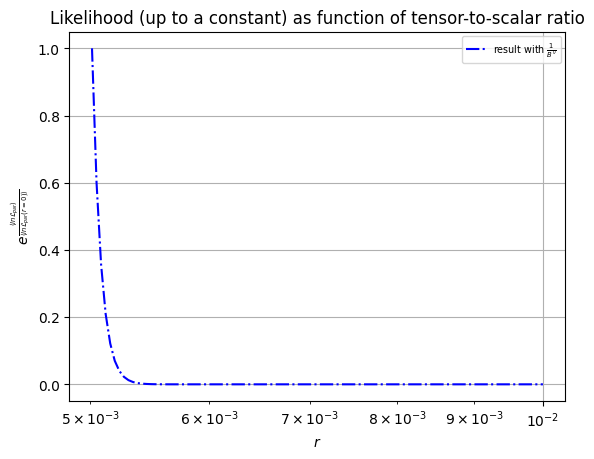

In [126]:
fig,ax = py.subplots()

# ax.plot(r_arr,np.exp((avg_cosmo_ren-y_ren)/2),'r-.', label = 'result with '+r'$\frac{B^c}{B^{\nu}}$')
ax.plot(r_arr,np.exp((y_inv0-y_inv)/2),'b-.',label = 'result with '+r'$\frac{1}{B^{\nu}}$')



py.title('Likelihood (up to a constant) as function of tensor-to-scalar ratio')
handles, labels = ax.get_legend_handles_labels()
py.xlabel(r'$r$')
py.ylabel(r'$e^{\frac{\langle ln \mathcal{L}_{par} \rangle}{\langle ln \mathcal{L}_{par}(r=0) \rangle}}$')

# py.ylabel(r'$e^{-1+\frac{\langle ln \mathcal{L}_{par} \rangle}{\langle ln \mathcal{L}_{par}(r=0) \rangle}}$')
# py.yscale("log")
py.xscale("log")
# py.xlim(0,1e-3)
py.grid()
# py.ylim(-1,1)

        #  of the residuals with and without beam, with noise')
# Set the background color of the plot
# ax.set_facecolor('gray')

# Set the background color of the figure
# ax.xaxis.label.set_color('white')
# ax.yaxis.label.set_color('white')
# ax.title.set_color('white')
# fig.set_facecolor('gray')

py.legend(handles,labels, loc = 'best', fontsize = 'x-small')
py.show()